In [20]:
! pip install netplotbrain
! pip install python-louvain


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\topk-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\topk-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [21]:
import scipy.io
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import networkx as nx
import netplotbrain
import pandas as pd
from community import community_louvain as louvain
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score


# Load DataSet

In [22]:
main_folder_path = './data/neurocon/'

Subjects = os.listdir(main_folder_path)
Subjects

['sub-control032014',
 'sub-control032015',
 'sub-control032016',
 'sub-control032017',
 'sub-control032018',
 'sub-control032019',
 'sub-control032020',
 'sub-control032021',
 'sub-control032022',
 'sub-control032023',
 'sub-control032024',
 'sub-control032025',
 'sub-control032026',
 'sub-control032028',
 'sub-control032029',
 'sub-patient032030',
 'sub-patient032031',
 'sub-patient032032',
 'sub-patient032034',
 'sub-patient032035',
 'sub-patient032036',
 'sub-patient032037',
 'sub-patient032038',
 'sub-patient032039',
 'sub-patient032040',
 'sub-patient032041',
 'sub-patient032042',
 'sub-patient032043',
 'sub-patient032044',
 'sub-patient032045',
 'sub-patient032046',
 'sub-patient032047',
 'sub-patient032048',
 'sub-patient032049',
 'sub-patient032050',
 'sub-patient032051',
 'sub-patient032052',
 'sub-patient032053',
 'sub-patient032054',
 'sub-patient032055',
 'sub-patient032056']

In [23]:
corr_aal_arr = []
corr_harvard_arr = []

for i in Subjects:
  print(f'loading... subject : {i}')
  path_aal=os.path.join(main_folder_path,i,f"{i}_AAL116_correlation_matrix.mat")
  path_harvard=os.path.join(main_folder_path,i,f"{i}_harvard48_correlation_matrix.mat" )
  mat_aal =scipy.io.loadmat(path_aal)
  mat_harvard =scipy.io.loadmat(path_harvard)
  data_aal = mat_aal["data"]
  data_harvard = mat_harvard["data"]
  corr_aal_arr.append(data_aal)
  corr_harvard_arr.append(data_harvard)
  print(f'loaded category:{i} successfully')

loading... subject : sub-control032014
loaded category:sub-control032014 successfully
loading... subject : sub-control032015
loaded category:sub-control032015 successfully
loading... subject : sub-control032016
loaded category:sub-control032016 successfully
loading... subject : sub-control032017
loaded category:sub-control032017 successfully
loading... subject : sub-control032018
loaded category:sub-control032018 successfully
loading... subject : sub-control032019
loaded category:sub-control032019 successfully
loading... subject : sub-control032020
loaded category:sub-control032020 successfully
loading... subject : sub-control032021
loaded category:sub-control032021 successfully
loading... subject : sub-control032022
loaded category:sub-control032022 successfully
loading... subject : sub-control032023
loaded category:sub-control032023 successfully
loading... subject : sub-control032024
loaded category:sub-control032024 successfully
loading... subject : sub-control032025
loaded category

In [24]:
subject_count = len(Subjects)
print(f"Subject Counts: {subject_count}" )

Subject Counts: 41


### Show example correlation matrix Harvard Atlas

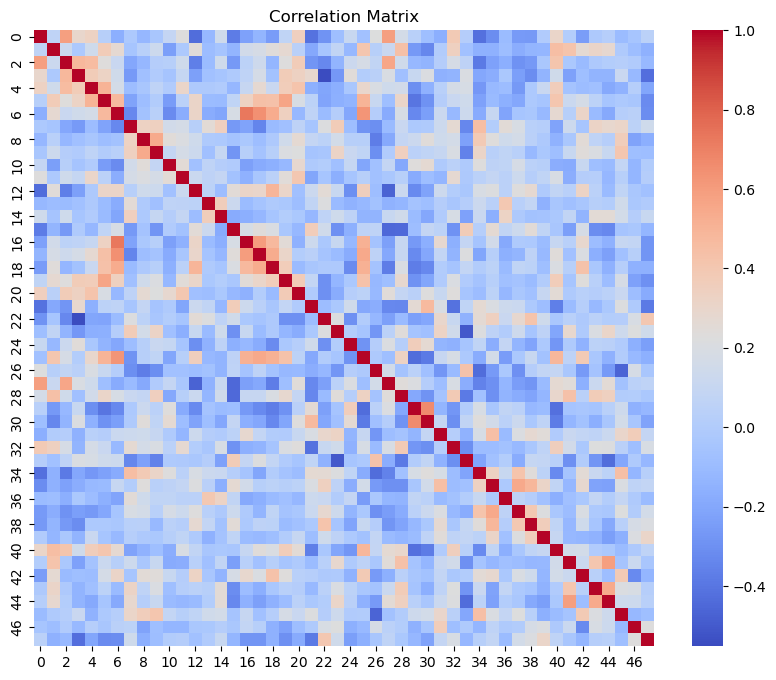

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_harvard_arr[0],  cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Show example nii data (one scan)

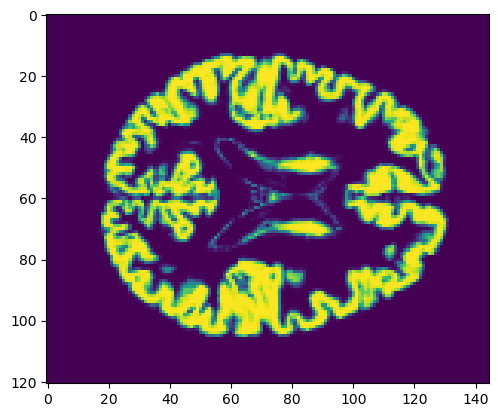

In [26]:
test_load = nib.load('.\data\wc1Sub001.nii').get_fdata()
test_load.shape
test = test_load[:,:,60]
plt.imshow(test)
plt.show()

In [27]:
threshold = 0.1  

adj_matrix_thresholded = np.where(corr_harvard_arr[0] >= threshold, 1, 0)
np.fill_diagonal(adj_matrix_thresholded, 0)

print(adj_matrix_thresholded)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


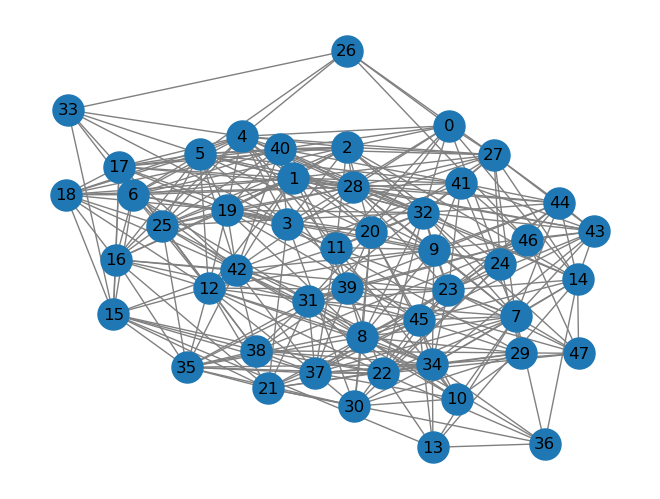

In [28]:
nx_network = nx.Graph(adj_matrix_thresholded)
nx.draw(nx_network, with_labels=True, node_size=500, edge_color='gray')
plt.show()

### Show Example in Brain Network

In [29]:
nodes_tf = {'atlas':'Schaefer2018',

'desc':'400Parcels7Networks',

'resolution': 1}

In [30]:
adj_array = np.array(adj_matrix_thresholded)
rows, cols = np.where(adj_array != 0)
weights = adj_array[rows, cols]
edges_df = pd.DataFrame({'i': rows, 'j': cols, 'weight': weights})

100%|██████████| 3.93M/3.93M [00:03<00:00, 1.02MB/s]


(<Figure size 900x300 with 3 Axes>,
 [<Axes3D: title={'center': 'Left'}>,
  <Axes3D: title={'center': 'Superior'}>,
  <Axes3D: title={'center': 'Right'}>])

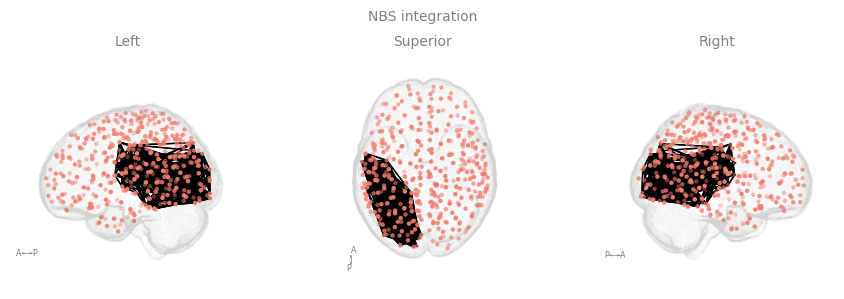

In [31]:

G = nx.karate_club_graph()

netplotbrain.plot(template='MNI152NLin2009cAsym', edges= edges_df, nodes=nodes_tf,
                            template_style='glass',
                            view=['LSR'],
                            title='NBS integration',
                            node_type='circles',
                            highlight_level=0.5)



# group-based community structure 

In [32]:
def Modularity_Clustering(G):
    partition = louvain.best_partition(G)

    communities = {}
    for node, cluster in partition.items():
        if cluster not in communities:
            communities[cluster] = [node]
        else:
            communities[cluster].append(node)
    return communities

def Plot_Comminuty(G, Clusters , title):
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)  
    for i, (nodes, color) in enumerate(zip(Clusters.values(), colors)):
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=200, label=f'Cluster {i+1}')
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_family='sans-serif')
    plt.title(title)
    plt.legend()
    plt.show()

## VTS Algorithm

    Calculation Average for all Density of subjects

In [33]:
avg_aal_matrices=[]
avg_harvard_matrices=[]

for corr in corr_harvard_arr:
    density_matrices = []
    for i in range(1, 51):
        threshold = i * 0.01
        adj_matrix_thresholded = np.where(corr >= threshold, 1, 0)
        np.fill_diagonal(adj_matrix_thresholded, 0)
        density_matrices.append(adj_matrix_thresholded)
    
    num_rows, num_cols = density_matrices[0].shape
    average_matrix = np.zeros((num_rows, num_cols))
    for matrix in density_matrices:
        average_matrix += matrix
    average_matrix /= 50
    avg_harvard_matrices.append(average_matrix)

for corr in corr_aal_arr:
    density_matrices = []
    for i in range(1, 51):
        threshold = i * 0.01
        adj_matrix_thresholded = np.where(corr >= threshold, 1, 0)
        np.fill_diagonal(adj_matrix_thresholded, 0)
        density_matrices.append(adj_matrix_thresholded)
    
    num_rows, num_cols = density_matrices[0].shape
    average_matrix = np.zeros((num_rows, num_cols))
    for matrix in density_matrices:
        average_matrix += matrix
    average_matrix /= 50
    avg_aal_matrices.append(average_matrix)

# avg for all harvard matrices
num_rows, num_cols = avg_harvard_matrices[0].shape
average_harvard_matrix = np.zeros((num_rows, num_cols))
for matrix in avg_harvard_matrices:
    average_harvard_matrix += matrix
average_harvard_matrix /= subject_count    

# avg for all aal matrices
num_rows, num_cols = avg_aal_matrices[0].shape
average_aal_matrix = np.zeros((num_rows, num_cols))
for matrix in avg_aal_matrices:
    average_aal_matrix += matrix
average_aal_matrix /= subject_count

print( "HARVARD:") 
print(average_harvard_matrix)

print( "AAL:") 
print(average_aal_matrix)


HARVARD:
[[0.         0.08097561 0.66341463 ... 0.12780488 0.10585366 0.01219512]
 [0.08097561 0.         0.09609756 ... 0.56878049 0.18439024 0.01804878]
 [0.66341463 0.09609756 0.         ... 0.06487805 0.14243902 0.01756098]
 ...
 [0.12780488 0.56878049 0.06487805 ... 0.         0.20292683 0.08      ]
 [0.10585366 0.18439024 0.14243902 ... 0.20292683 0.         0.39414634]
 [0.01219512 0.01804878 0.01756098 ... 0.08       0.39414634 0.        ]]
AAL:
[[0.         0.91317073 0.59512195 ... 0.08682927 0.12634146 0.07756098]
 [0.91317073 0.         0.48585366 ... 0.11219512 0.12682927 0.07219512]
 [0.59512195 0.48585366 0.         ... 0.09365854 0.10097561 0.09414634]
 ...
 [0.08682927 0.11219512 0.09365854 ... 0.         0.5102439  0.15268293]
 [0.12634146 0.12682927 0.10097561 ... 0.5102439  0.         0.15073171]
 [0.07756098 0.07219512 0.09414634 ... 0.15268293 0.15073171 0.        ]]


    Modularity Clustering

{3: [0, 2, 3, 4, 5, 6, 16, 17, 18, 19, 25, 27, 28, 40], 1: [1, 9, 41, 42, 43, 44, 45], 2: [7, 8, 10, 11, 12, 13, 14, 15, 24, 26, 32, 33, 34, 36, 37], 4: [20, 21, 29, 30], 0: [22, 23, 31, 35, 38, 39, 46, 47]}


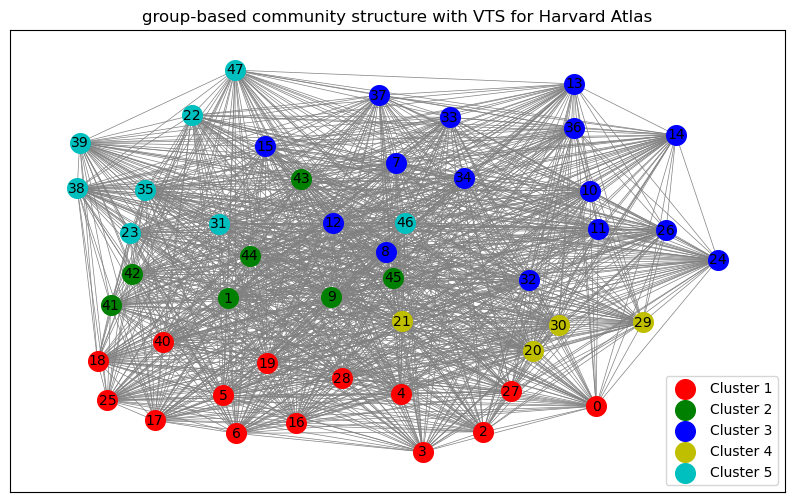

In [35]:
G_harvard_averaged = nx.Graph(average_harvard_matrix)


clusters = Modularity_Clustering(G_harvard_averaged)
print(clusters)
GroupBaseComminuty_VTS_HARVARD = (G_harvard_averaged ,clusters )
Plot_Comminuty(GroupBaseComminuty_VTS_HARVARD[0],GroupBaseComminuty_VTS_HARVARD[1], 'group-based community structure with VTS for Harvard Atlas')

{0: [0, 1, 2, 3, 6, 7, 10, 11, 12, 13, 18, 19, 22, 23, 32, 33, 34, 35, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], 1: [4, 5, 8, 9, 14, 20, 21, 24, 25, 26, 27, 30, 31, 70, 71], 2: [15, 16, 17, 28, 29, 36, 37, 38, 39, 40, 41, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 94, 95], 3: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]}


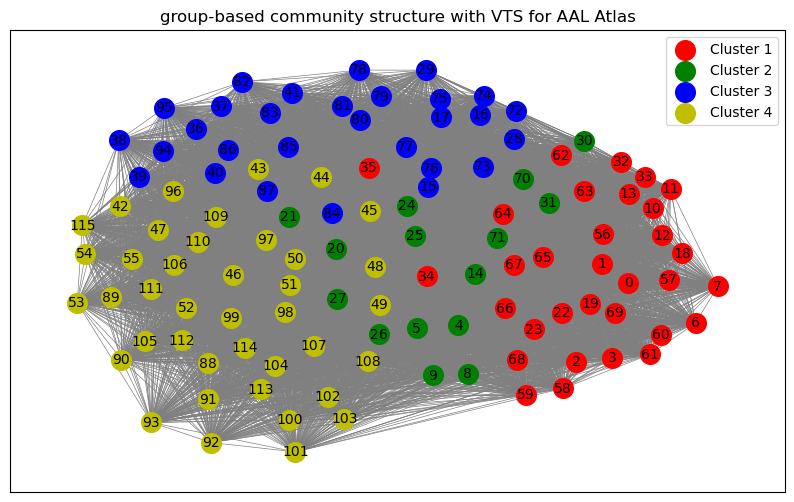

In [36]:
G_aal_averaged = nx.Graph(average_aal_matrix)
clusters = Modularity_Clustering(G_aal_averaged)
print(clusters)
GroupBaseComminuty_VTS_AAL = (G_aal_averaged ,clusters )
Plot_Comminuty(GroupBaseComminuty_VTS_AAL[0],GroupBaseComminuty_VTS_AAL[1], 'group-based community structure with VTS for AAL Atlas')

## IS Algorithm 

In [37]:
lable_aal_arr=[]
cluster_aal_arr=[]
lable_harvard_arr=[]
cluster_harvard_arr=[]

for corr in corr_harvard_arr:        
    # get avg for all densities
    density_matrices = []
    for i in range(1, 51):
        threshold = i * 0.01
        adj_matrix_thresholded = np.where(corr >= threshold, 1, 0)
        np.fill_diagonal(adj_matrix_thresholded, 0)
        density_matrices.append(adj_matrix_thresholded)
    num_rows, num_cols = density_matrices[0].shape
    average_matrix = np.zeros((num_rows, num_cols))
    for matrix in density_matrices:
        average_matrix += matrix
    average_matrix /= 50

    G= nx.Graph(average_matrix)
    clusters = Modularity_Clustering(G)
    cluster_harvard_arr.append((G,clusters))
    
    labls = np.zeros(num_rows)
    for i in clusters:
        for j in clusters.get(i):
            labls[j] = i

    lable_harvard_arr.append(labls)

for corr in corr_aal_arr:        
    # get avg for all densities
    density_matrices = []
    for i in range(1, 51):
        threshold = i * 0.01
        adj_matrix_thresholded = np.where(corr >= threshold, 1, 0)
        np.fill_diagonal(adj_matrix_thresholded, 0)
        density_matrices.append(adj_matrix_thresholded)
    num_rows, num_cols = density_matrices[0].shape
    average_matrix = np.zeros((num_rows, num_cols))
    for matrix in density_matrices:
        average_matrix += matrix
    average_matrix /= 50

    G= nx.Graph(average_matrix)
    clusters = Modularity_Clustering(G)
    cluster_aal_arr.append((G,clusters))
    
    labls = np.zeros(num_rows)
    for i in clusters:
        for j in clusters.get(i):
            labls[j] = i

    lable_aal_arr.append(labls)



In [38]:
nmi_avg_harvard_arr = []
nmi_avg_aal_arr = []

for lables in lable_harvard_arr:
    nmi_arr= []
    for labls2 in lable_harvard_arr:
        nmi = normalized_mutual_info_score(lables , labls2)
        nmi_arr.append(nmi)
    nmi_avg_harvard_arr.append(np.mean(nmi_arr))

for lables in lable_aal_arr:
    nmi_arr= []
    for labls2 in lable_aal_arr:
        nmi = normalized_mutual_info_score(lables , labls2)
        nmi_arr.append(nmi)
    nmi_avg_aal_arr.append(np.mean(nmi_arr))



NMI of Max is 0.3740150664759294 and index is 6


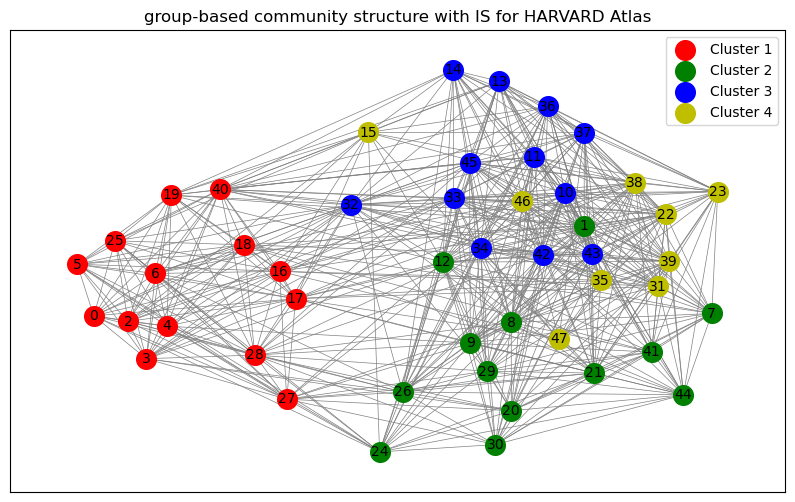

In [39]:
index_select = np.argmax(nmi_avg_harvard_arr)

print(f"NMI of Max is {nmi_avg_harvard_arr[index_select]} and index is {index_select}")
GroupBaseComminuty_IS_HARVARD = (cluster_harvard_arr[index_select][0], cluster_harvard_arr[index_select][1])
Plot_Comminuty(GroupBaseComminuty_IS_HARVARD[0],GroupBaseComminuty_IS_HARVARD[1], 'group-based community structure with IS for HARVARD Atlas')

NMI of Max is 0.28541824821672457 and index is 29


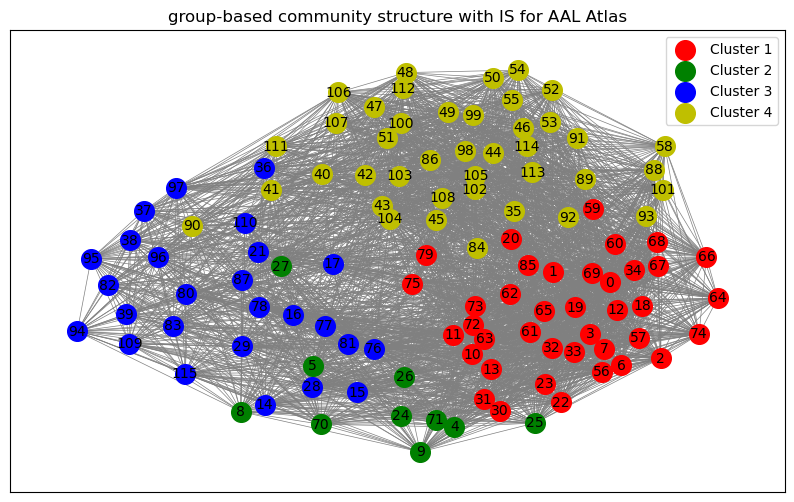

In [40]:
index_select = np.argmax(nmi_avg_aal_arr)

print(f"NMI of Max is {nmi_avg_aal_arr[index_select]} and index is {index_select}")
GroupBaseComminuty_IS_AAL = (cluster_aal_arr[index_select][0], cluster_aal_arr[index_select][1])
Plot_Comminuty(GroupBaseComminuty_IS_AAL[0],GroupBaseComminuty_IS_AAL[1], 'group-based community structure with IS for AAL Atlas')

# Compare

In [81]:
def Get_Lables(clusters , atlas_type ='AAL'):
    dim = 1
    if(atlas_type == 'AAL'):
        dim = 116
    elif(atlas_type == 'HARVARD'):
        dim = 48
    
    labls = np.zeros(dim)
    for i in clusters:
        for j in clusters.get(i):
            labls[j] = i
    
    return labls

## Group-Base Comminuty VTS HARVARD

In [82]:
GroupBaseComminuty_VTS_HARVARD_lables = Get_Lables( GroupBaseComminuty_VTS_HARVARD[1], 'HARVARD')

GroupBaseComminuty_VTS_HARVARD_lables

array([3., 1., 3., 3., 3., 3., 3., 2., 2., 1., 2., 2., 2., 2., 2., 2., 3.,
       3., 3., 3., 4., 4., 0., 0., 2., 3., 2., 3., 3., 4., 4., 0., 2., 2.,
       2., 0., 2., 2., 0., 0., 3., 1., 1., 1., 1., 1., 0., 0.])

In [84]:
lable_harvard_arr=[]


for corr in corr_harvard_arr:        
    ## density 1-50
    for i in range(1, 51):
        threshold = i * 0.01
        adj_matrix_thresholded = np.where(corr >= threshold, 1, 0)

        # 100 iteration permutation 
        for p  in range(1,10):
            adj_matrix_thresholded_permuted = np.random.permutation(adj_matrix_thresholded)

            np.fill_diagonal(adj_matrix_thresholded_permuted, 0)
            G= nx.Graph(adj_matrix_thresholded_permuted)
            clusters = Modularity_Clustering(G)

            num_rows, num_cols = adj_matrix_thresholded_permuted.shape
            labls = np.zeros(num_rows)
            for c in clusters:
                for j in clusters.get(c):
                    labls[j] = c     
            lable_harvard_arr.append(labls)


In [85]:
nmi_VTS_harvard_arr=[]
for i in lable_harvard_arr:
    nmi_VTS_harvard_arr.append(normalized_mutual_info_score(GroupBaseComminuty_VTS_HARVARD_lables , i))

print(f"Average of NMI With VTS Approuch in Harvard Atlas = {np.mean(nmi_VTS_harvard_arr)}")

Average of NMI With VTS Approuch in Harvard Atlas = 0.192954859727868


## Group-Base Comminuty VTS AAL

In [89]:
GroupBaseComminuty_VTS_AAL_lables = Get_Lables( GroupBaseComminuty_VTS_AAL[1], 'AAL')

GroupBaseComminuty_VTS_AAL_lables


array([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 2., 2.,
       2., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 2., 2., 1., 1., 0., 0.,
       0., 0., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [91]:

lable_aal_arr=[]


for corr in corr_aal_arr:        
    ## density 1-50
    for i in range(1, 51):
        threshold = i * 0.01
        adj_matrix_thresholded = np.where(corr >= threshold, 1, 0)

        # 100 iteration permutation 
        for p  in range(1,10):
            adj_matrix_thresholded_permuted = np.random.permutation(adj_matrix_thresholded)

            np.fill_diagonal(adj_matrix_thresholded_permuted, 0)
            G= nx.Graph(adj_matrix_thresholded_permuted)
            clusters = Modularity_Clustering(G)

            num_rows, num_cols = adj_matrix_thresholded_permuted.shape
            labls = np.zeros(num_rows)
            for c in clusters:
                for j in clusters.get(c):
                    labls[j] = c     
            lable_aal_arr.append(labls)



In [ ]:


nmi_VTS_aal_arr=[]
for i in lable_aal_arr:
    nmi_VTS_aal_arr.append(normalized_mutual_info_score(GroupBaseComminuty_VTS_AAL_lables , i))

print(f"Average of NMI With VTS Approuch in AAL Atlas = {np.mean(nmi_VTS_aal_arr)}")

## Group-Base Comminuty IS HARVARD

In [87]:
GroupBaseComminuty_IS_HARVARD_lables = Get_Lables( GroupBaseComminuty_IS_HARVARD[1], 'HARVARD')

GroupBaseComminuty_IS_HARVARD_lables

array([0., 2., 0., 0., 0., 0., 0., 2., 2., 2., 3., 3., 2., 3., 3., 1., 0.,
       0., 0., 0., 2., 2., 1., 1., 2., 0., 2., 0., 0., 2., 2., 1., 3., 3.,
       3., 1., 3., 3., 1., 1., 0., 2., 3., 3., 2., 3., 1., 1.])

In [88]:
nmi_IS_HARVARD_arr=[]
for i in lable_harvard_arr:
    nmi_IS_HARVARD_arr.append(normalized_mutual_info_score(GroupBaseComminuty_IS_HARVARD_lables , i))

print(f"Average of NMI With IS Approuch in HARVARD Atlas = {np.mean(nmi_IS_HARVARD_arr)}")

Average of NMI With IS Approuch in HARVARD Atlas = 0.1486208117009212


## Group-Base Comminuty IS AAL

In [78]:
GroupBaseComminuty_IS_AAL_lables = Get_Lables( GroupBaseComminuty_IS_AAL[1], 'AAL')

GroupBaseComminuty_IS_AAL_lables

array([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 3., 3., 3.,
       3., 0., 0., 0., 3., 0., 0., 1., 1., 1., 1., 3., 3., 0., 0., 0., 0.,
       0., 2., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 3., 3., 3., 0., 3., 3., 3., 3., 2.,
       0., 2., 3., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 3., 3., 2., 2., 2., 2., 3.])

In [79]:
nmi_IS_AAL_arr=[]
for i in lable_aal_arr:
    nmi_IS_AAL_arr.append(normalized_mutual_info_score(GroupBaseComminuty_IS_AAL_lables , i))

print(f"Average of NMI With IS Approuch in AAL Atlas = {np.mean(nmi_IS_AAL_arr)}")

Average of NMI With IS Approuch in AAL Atlas = 0.11992936503692017


        The  Best Group-Based Community is VTS and HARVARD